# Introdcution

In this project we will be creating an algorithm to identify metastatic cancer in image patches taken. There are about 220,000 labeled images and the images are 96x96 pixels in the form of .tif. The success of this algorithm will be measured by an ROC Curve (AUC). The challenge information can be found on the kaggle website with this link https://www.kaggle.com/c/histopathologic-cancer-detection/overview

### Goal

The goal of this project is to identitfy cancer in images with a high accuracy. 

### Data Overview

- Each image is 96x96
- Training set: ~220,000 labeled images
- Test set: ~57,000 unlabeled images

## Exploratory Data Analysis (EDA)

First we need to download the packages we need too.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input


### Load data

In [2]:
df = pd.read_csv("train_labels.csv")
df["image_path"] = "train/" + df["id"] + ".tif"
df["label"] = df["label"].astype(str)

df_test = pd.read_csv("sample_submission.csv")
df_test["image_path"] = "test/" + df_test["id"] + ".tif"

### Exploring the Data

Lets see the distribution of data between photos with cancer and without cancer. A bar chart will show if there is an even or uneven amount of positve and false cases

label
0    130908
1     89117
Name: count, dtype: int64


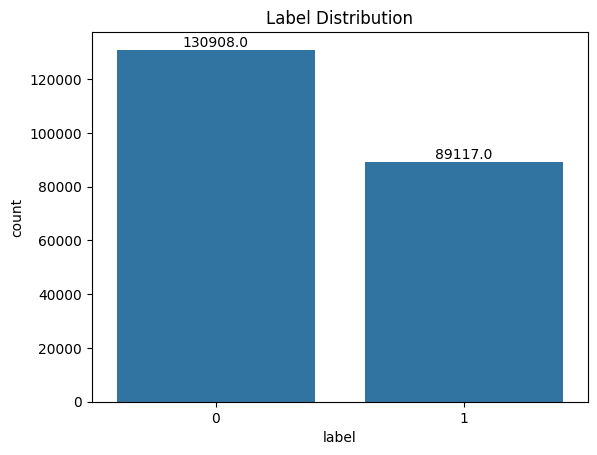

In [3]:
print(df["label"].value_counts())

ax = sns.countplot(x='label', data=df)
plt.title("Label Distribution")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
plt.show()

As you can see from the bar chart there is definitely more negative cases than positive cases. 

### Visual of the Photos

Lets first see what our images look like. There will be an example image if there was no cancer labeled 0 and a photo that has cancer with the label 1. We are going to look at the first 5 photos. 

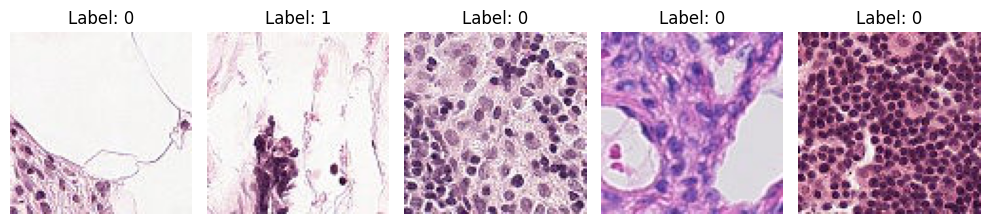

In [4]:
plt.figure(figsize=(10,5))
for i in range(5):
    img_id = df.iloc[i]['id']
    label = df.iloc[i]['label']
    img = Image.open(os.path.join("train", img_id + ".tif"))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title("Label: " + str(label))
    plt.axis('off')
plt.tight_layout()
plt.show()

### Preparing and Cleaning the Data

First we split the data into training and validation sets with a 90/10 split. We then normalized the images to help with the imbalanced seen in the barchart. We then used ImageDataGenerator to create pipelines for the training, validation, and test sets. The training generator will flip the images around and flip them on the verticle axis to help with overfitting the image data. I also ran into run time issues so the generators load the images more efficiently to help reduce processing time. 



In [5]:
train_data, val_data = train_test_split(df, test_size=0.1, random_state=0)

train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_loader = train_gen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

val_loader = val_gen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)

test_loader = test_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image_path',
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


Found 198022 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


## DModel Architecture 

For this project I chose to use a Convolutional Neural Network (CNN) with two convolution layers, ReLU activations, max pooling and a dense output. This is commonly used in image classification because its quick and easy to use but also effective. We will then compare our results to another model which will have 3 convolution layers and a dropout method to help with overfitting the data. We will call these two models model 1 and model 2 when we are comparing the two. We will then compare the accuracy of the two models. 

### Model 1

Model 1 is a simple Convolutional Neural Network (CNN) that has two convolution layers with max pooling and a dense layer. It also includes a dropout layers before we compile for the result. We will run 10 epochs for this model. 

In [6]:
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history1 = model1.fit(
    train_loader,
    steps_per_epoch=len(train_data) // 32,
    validation_data=val_loader,
    validation_steps=len(val_data) // 32,
    epochs=10
)



C:\Users\Grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 1821s 294ms/step - accuracy: 0.7818 - loss: 0.4729 - val_accuracy: 0.8557 - val_loss: 0.3306
Epoch 2/10
   1/6188 ━━━━━━━━━━━━━━━━━━━━ 8:25 82ms/step - accuracy: 0.7188 - loss: 0.5350

C:\Users\Grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6188/6188 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7188 - loss: 0.5350 - val_accuracy: 0.8546 - val_loss: 0.3329
Epoch 3/10
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 1377s 222ms/step - accuracy: 0.8612 - loss: 0.3346 - val_accuracy: 0.8790 - val_loss: 0.2932
Epoch 4/10
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.8125 - loss: 0.4021 - val_accuracy: 0.8814 - val_loss: 0.2904
Epoch 5/10
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 440s 71ms/step - accuracy: 0.8782 - loss: 0.2978 - val_accuracy: 0.8821 - val_loss: 0.2907
Epoch 6/10
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9062 - loss: 0.1710 - val_accuracy: 0.8843 - val_loss: 0.2839
Epoch 7/10
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 445s 72ms/step - accuracy: 0.8893 - loss: 0.2746 - val_accuracy: 0.8959 - val_loss: 0.2563
Epoch 8/10
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8125 - loss: 0.4208 - val_accuracy: 0.8963 - val_loss: 0.2540
Epoch 9/10
6188/6188 ━━━━━━━━━━━━━━━━━━━━ 1415s 229ms/step - accuracy: 0.8967 - loss: 

## Tuning Parameters

In the first model we used the adam optimizer. In this case we are going to manually controller the parameters by adjusting the learning rate and the momentum. This could help reduce overfitting the data. We will be using the learning rate of 0.001 over 5 epochs and a btach size of 32. 

In [7]:
from tensorflow.keras import optimizers
model1op = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimized = optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model1op.compile(optimizer=optimized, loss='binary_crossentropy', metrics=['accuracy'])

history2 = model1op.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10
)


Epoch 1/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 501s 81ms/step - accuracy: 0.7401 - loss: 0.5245 - val_accuracy: 0.7715 - val_loss: 0.4835
Epoch 2/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 462s 75ms/step - accuracy: 0.8201 - loss: 0.4090 - val_accuracy: 0.8415 - val_loss: 0.3656
Epoch 3/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 514s 83ms/step - accuracy: 0.8437 - loss: 0.3654 - val_accuracy: 0.8601 - val_loss: 0.3369
Epoch 4/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 499s 81ms/step - accuracy: 0.8539 - loss: 0.3439 - val_accuracy: 0.8615 - val_loss: 0.3252
Epoch 5/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 488s 79ms/step - accuracy: 0.8623 - loss: 0.3249 - val_accuracy: 0.8756 - val_loss: 0.2922
Epoch 6/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 456s 74ms/step - accuracy: 0.8707 - loss: 0.3099 - val_accuracy: 0.8831 - val_loss: 0.2800
Epoch 7/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 540s 87ms/step - accuracy: 0.8784 - loss: 0.2935 - val_accuracy: 0.8828 - val_loss: 0.2811
Epoch 8/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 541s 87ms/step - accuracy: 

Now lets compare model 1 and optimized model 1

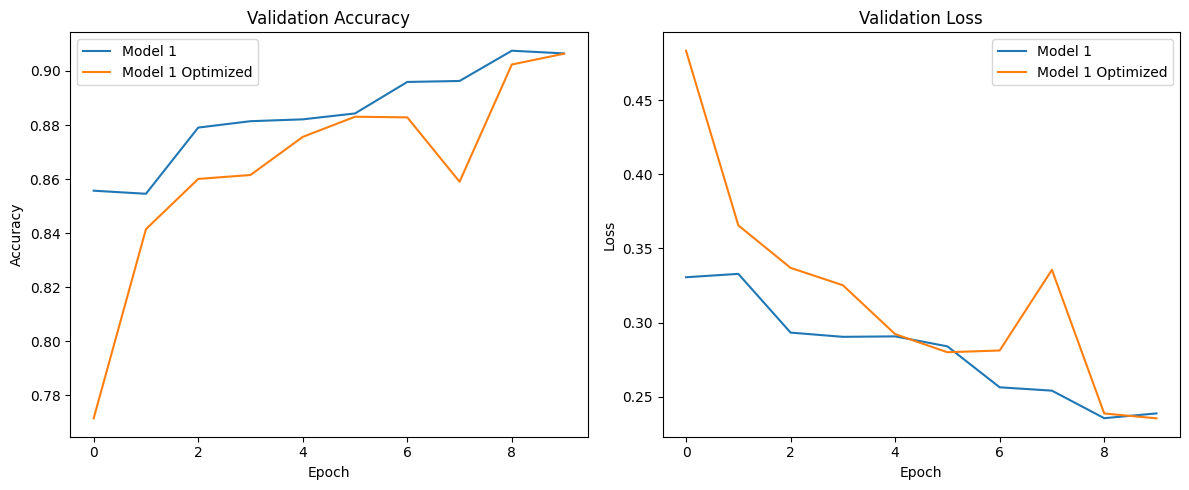

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['val_accuracy'], label='Model 1')
plt.plot(history2.history['val_accuracy'], label='Model 1 Optimized')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'], label='Model 1')
plt.plot(history2.history['val_loss'], label='Model 1 Optimized')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

After tuning it seems like the adam optimization still performed better. It had overall better accuracy and had a lower loss. We will now compare model 1 with model 2.

### Model 2

Model 2 is similar to model 1 but it adds an extra convolution layer. It also adds a dropout layer after each convolution layer instead of at the end like in model 1. It also has a dense layer after each convolution to help with overfitting the data. Its still a simple model but it much more complex than model 1. 

In [9]:
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D(2,2),
    Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history3 = model2.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10
)

Epoch 1/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 696s 112ms/step - accuracy: 0.7383 - loss: 0.5129 - val_accuracy: 0.7785 - val_loss: 0.4589
Epoch 2/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 1317s 213ms/step - accuracy: 0.8346 - loss: 0.3849 - val_accuracy: 0.8278 - val_loss: 0.4142
Epoch 3/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 1201s 194ms/step - accuracy: 0.8422 - loss: 0.3665 - val_accuracy: 0.8176 - val_loss: 0.4228
Epoch 4/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 699s 113ms/step - accuracy: 0.8489 - loss: 0.3557 - val_accuracy: 0.8258 - val_loss: 0.4129
Epoch 5/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 661s 107ms/step - accuracy: 0.8522 - loss: 0.3485 - val_accuracy: 0.8467 - val_loss: 0.3947
Epoch 6/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 695s 112ms/step - accuracy: 0.8557 - loss: 0.3432 - val_accuracy: 0.8543 - val_loss: 0.3817
Epoch 7/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 652s 105ms/step - accuracy: 0.8557 - loss: 0.3434 - val_accuracy: 0.8515 - val_loss: 0.3982
Epoch 8/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 649s 105ms/step - 

## Results and Analysis

We will now compare model 1 to model 2. 

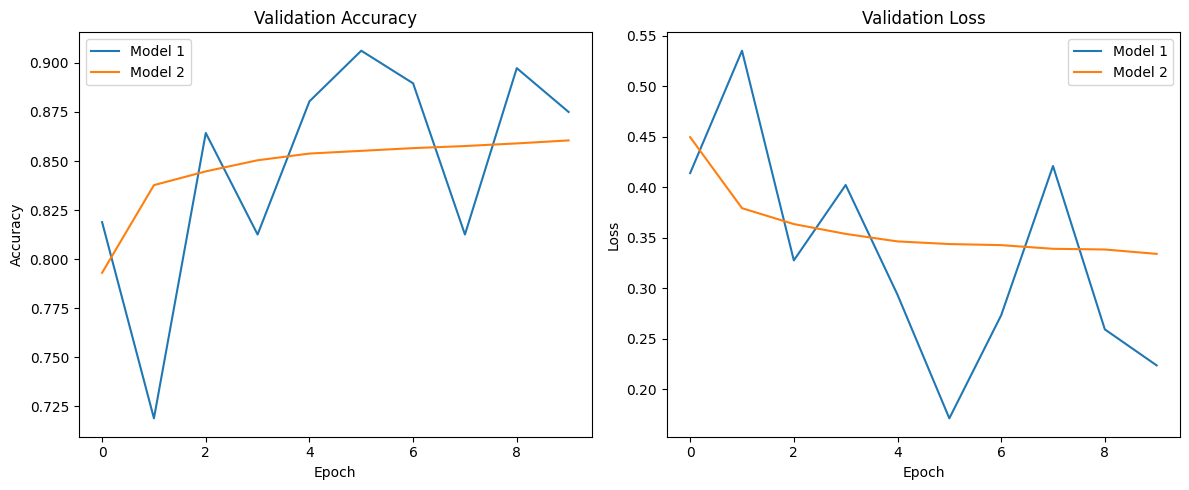

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1')
plt.plot(history3.history['accuracy'], label='Model 2')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Model 1')
plt.plot(history3.history['loss'], label='Model 2')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


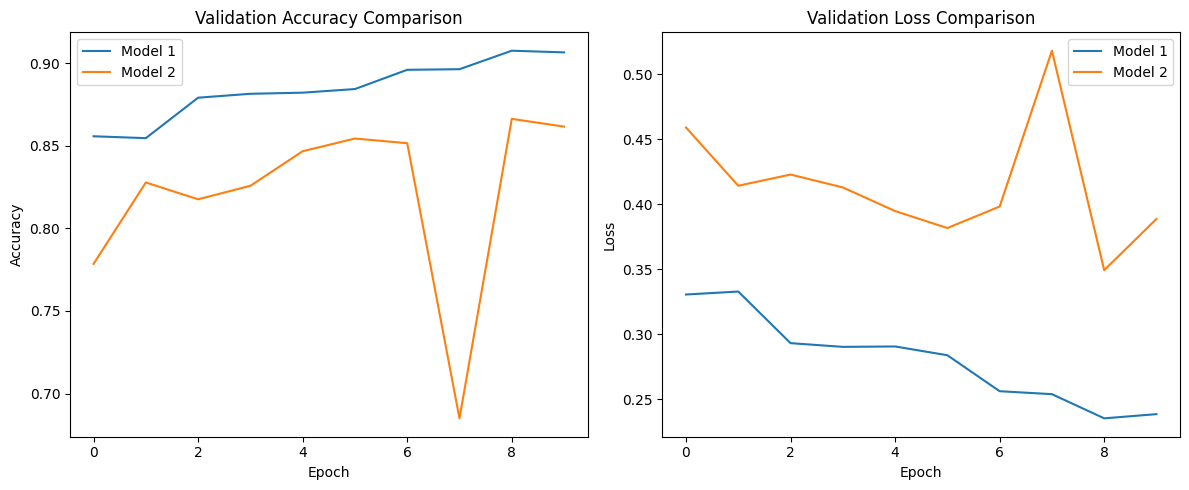

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['val_accuracy'], label='Model 1')
plt.plot(history3.history['val_accuracy'], label='Model 2')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['val_loss'], label='Model 1')
plt.plot(history3.history['val_loss'], label='Model 2')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

After looking at the results it seems that model 1 performed much better than model 2 with accuracy and loss. Model one achieved a highest accuracy of about 0.9 at an epoch of 4. Model 1 also had the lowest validation loss. 

## Analysis Discussion 

Overall we evaluated three different models. 

Model 1: A normal CNN model with two convolution layers, using the adam optimizer, and a dropout before the final dense layer. 
Model 1 optimized: Identical to model 1, but we mainly changed the learning rate and the momentum. 
Model 2: A normal CNN model with three convolution layers, dropout after each convolution block, and an additional dense layer.

All three model used 5 epochs for training and all them used the same augmentation and normalization for consistency. 

The perforance for each model is below:
Model 1 - Final val accuracy: ~0.885
Model 1 Optimized - Final val accuracy: ~0.865
Model 2 - Final val accuracy: ~0.841

Overall model 1 performed the best. 

## Conclusion

In this project we compared multiple CNN models to detect cancer within histopathologic images. Among the models reviewed model 1 ahcieved the best validation performance with an accuracy of ___ and the lowestest loss of ____. Optimizing the model with additional layers and dropouts did not yield better results in the end. In the future I think it would be best to include more epochs and try more learning rates to increase performance. Also it would be helpful to increase the efficiency of the model because increasing the number of epochs drastically increases the runtime. 